# Übungsblatt 9

**Lernziele**
In den Übungen dieser Wochen lernen Sie:
* Öffnen, Schließen, Lesen und Schreiben von Textdateien.
* Definieren, Werfen und Fangen von (eigenen) Ausnahmen.
* Funktionen des `String`-Moduls einzusetzen um Zeichenketten zu durchsuchen und zu manipulieren.
* Funktionalen Programmcode mithilfe von verschiedenen Operatoren übersichtlicher zu strukturieren.
* Die Semantik einer polymorphen Funktion aus deren Typ herzuleiten.

## Aufgabe 9.1 (P) Statistik

Implementieren Sie eine Funtion `do_statistics : string -> string -> unit`, die eine
Textdatei (1. Argument) einliest, eine Statistik über deren Inhalt erstellt und diese
in eine Ausgabedatei (2. Argument) schreibt. Die Statistik soll dabei alle vorkommenden
Wörter, sowie deren Häufigkeit in der Eingabedatei enthalten.

Um einen String `s`  in die einzelnen
Wörter zu unterteilen, nutzen Sie zuerst `String.split_on_char ' ' s`. Welches
Problem tritt auf? Versuchen Sie anschließend `Str.split (Str.regexp "[^a-zA-Z]") s`
aus dem `Str`-Modul um den String in die einzelnen Wörter zu unterteilen. Groß- und
Kleinschreibung soll dabei ignoriert werden, die Statistik ist also Case-Insensitiv.

Die
Ausgabedatei soll dann für jedes Wort `word` mit Häufigkeit `count` eine Zeile `word=count`
enthalten, wobei die Wörter alphabetisch sortiert sein sollen. Die Funktion soll außerdem
eine Ausnahme `File_empty`, deren einziges Argument der Dateiname ist, werfen, wenn die
Eingabedatei keine Wörter enthält. Achten Sie darauf, dass in jedem Fall alle geöffneten
Dateien auch wieder ordnungsgemäß geschlossen werden.

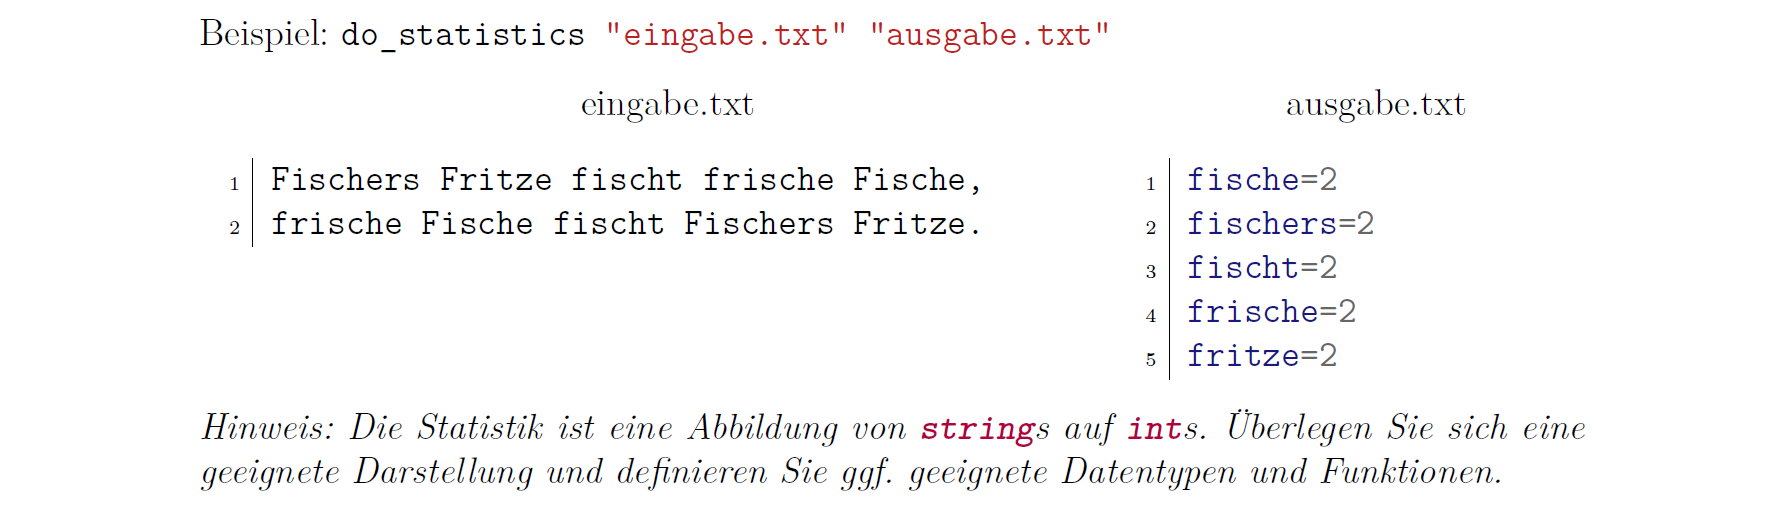

In [1]:
String.split_on_char

- : char -> string -> string list = <fun>


In [2]:
String.length

- : string -> int = <fun>


In [3]:
String.lowercase_ascii

- : string -> string = <fun>


Mit dem `Str`-Modul können komplexere Operationen auf Strings durchgeführt werden. Dazu verwenden wir unter anderem reguläre Ausdrücke. Mehr dazu in der Vorlesung "Theoretische Informatik" nächstes Semester. Dieses Modul müssen wir explizit laden.

In [4]:
#require "str" (* #load "str.cma" *)

/home/vagrant/.opam/4.04.2/lib/ocaml/str.cma: loaded


In [5]:
Str.split

- : Str.regexp -> string -> string list = <fun>


In [6]:
Str.regexp

- : string -> Str.regexp = <fun>


Außerdem wollen wir noch Dateien einlesen und beschreiben. Hierfür gibt es die folgenden Funktionen aus der Standardlibrary.

In [7]:
(* zum lesen: *)
open_in                       ;;
input_line                    ;;
close_in

- : string -> in_channel = <fun>


- : in_channel -> string = <fun>


- : in_channel -> unit = <fun>


In [8]:
(* zum schreiben: *)
open_out                      ;;
Printf.fprintf                ;;
close_out

- : string -> out_channel = <fun>


- : out_channel -> ('a, out_channel, unit) format -> 'a = <fun>


- : out_channel -> unit = <fun>


Für diese Aufgabe benötigen wir zusätzlich noch Exceptions in OCaml. Diese funktionieren nicht anders als in Java. Statt `throw` verwenden wir `raise` und statt `try ... catch` gibt es `try ... with` und einem anschließenden Pattern Matching auf die geworfene Exception.

In [9]:
End_of_file

- : exn = End_of_file


In [10]:
exception File_empty of string

exception File_empty of string


In [11]:
File_empty "test.txt"

- : exn = File_empty "test.txt"


In [12]:
let f () = raise (File_empty "test.txt")

val f : unit -> 'a = <fun>


In [13]:
f ()

error: error

In [14]:
try
  f ()
with
  End_of_file -> "End of file exception"
| File_empty s -> "File empty exception: " ^ s

- : string = "File empty exception: test.txt"


Mit diesen Informationen können wir uns an die eigentliche Aufgabe wagen. Zunächst definieren wir uns eine Funktion, die eine gegebene Zeile in die Statistik einträgt.

In [15]:
let analyze_word stats word =
  let word = String.lowercase_ascii word in
  if List.mem_assoc word stats then
    let value = List.assoc word stats in
    let stats = List.remove_assoc word stats in
    (word, value + 1) :: stats
  else
    (word, 1) :: stats

let analyze_line stats line =
  let words : string list = Str.split (Str.regexp "[^a-zA-Z]+") line in
  List.fold_left analyze_word stats words

val analyze_word : (string * int) list -> string -> (string * int) list =
  <fun>


val analyze_line : (string * int) list -> string -> (string * int) list =
  <fun>


Das Aufteilen unseres Programms in kleinere Funktionen erlaubt auch, diese Funktionen einzeln zu testen. So können wir schnell feststellen, ob dieser Teil korrekt ist.

In [16]:
analyze_word [("abc", 4); ("def", 7)] "abc"

- : (string * int) list = [("abc", 5); ("def", 7)]


In [17]:
analyze_word [("abc", 4); ("def", 7)] "xyz"

- : (string * int) list = [("xyz", 1); ("abc", 4); ("def", 7)]


In [18]:
analyze_line [("abc", 4); ("def", 7)] "abc xyz abc"

- : (string * int) list = [("abc", 6); ("xyz", 1); ("def", 7)]


Diese Funktionen können wir jetzt in unserem eigentlichen Progrmam `do_statistics` verwenden, wo wir uns nur noch um das Einlesen und Schreiben der Dateien kümmern müssen.

In [19]:
let do_statistics input_file output_file =
  let input = open_in input_file in
  let rec read stats =
    try
      input_line input
      |> analyze_line stats
      |> read
    with
      End_of_file -> stats
  in
  let stats = read [] in
  close_in input;
  if stats = [] then
    raise (File_empty input_file)
  else
    let stats = List.sort (fun (k1, _) (k2, _) -> compare k1 k2) stats in
    let output = open_out output_file in
    List.iter (fun (k, v) -> Printf.fprintf output "%s=%d\n" k v) stats;
    close_out output

val do_statistics : string -> string -> unit = <fun>


In [20]:
do_statistics "files/song.txt" "files/stats.txt"

- : unit = ()


## Aufgabe 9.2 (P) Pointless composition

Überlegen Sie sich für was die folgenden Operatoren nützlich sein könnten:

```ocaml
(@@) : ('a -> 'b) -> 'a -> 'b
(|>) : 'a -> ('a -> 'b) -> 'b
(%)  : ('a -> 'b) -> ('c -> 'a) -> 'c -> 'b
(%>) : ('a -> 'b) -> ('b -> 'c) -> 'a -> 'c
```

*Hinweis*: Die beiden Operatoren `%` und `%>` sind aus der Library "OCaml Batteries Included" und muss extra installiert werden.

In [21]:
let (@@) f x = f x

val ( @@ ) : ('a -> 'b) -> 'a -> 'b = <fun>


In [22]:
let (|>) x f = f x

val ( |> ) : 'a -> ('a -> 'b) -> 'b = <fun>


In [23]:
let (%) f g x = f (g x)

val ( % ) : ('a -> 'b) -> ('c -> 'a) -> 'c -> 'b = <fun>


In [24]:
let (%>) f g x = g (f x)

val ( %> ) : ('a -> 'b) -> ('b -> 'c) -> 'a -> 'c = <fun>


In [25]:
fun f g h i j -> f (g (h (i j)))

- : ('a -> 'b) -> ('c -> 'a) -> ('d -> 'c) -> ('e -> 'd) -> 'e -> 'b = <fun>


In [26]:
fun f g h i j -> f @@ g @@ h @@ i @@ j

- : ('a -> 'b) -> ('c -> 'a) -> ('d -> 'c) -> ('e -> 'd) -> 'e -> 'b = <fun>


In [27]:
fun f g h i j -> j |> i |> h |> g |> f

- : ('a -> 'b) -> ('c -> 'a) -> ('d -> 'c) -> ('e -> 'd) -> 'e -> 'b = <fun>


In [28]:
let times2 x = 2 * x

val times2 : int -> int = <fun>


In [29]:
let plus7 x = x + 7

val plus7 : int -> int = <fun>


In [30]:
let times2plus7 = plus7 % times2

val times2plus7 : int -> int = <fun>


In [31]:
let plus7times2 = plus7 %> times2

val plus7times2 : int -> int = <fun>


## Aufgabe 9.3 (P) Type-driven development

Geben Sie für die folgenden Typen alle semantisch unterschiedlichen Ausdrücke an, die
den gleichen Typ erhalten würden. Funktionen definieren wir hier als semantisch gleich,
falls diese für alle Eingaben, die gleichen Ausgaben liefern, d.h. Seiteneffekte werden nicht
beachtet. Versuchen Sie bei den Funktionen mit nur einer Implementierung zu verstehen,
was diese tun.

*Bemerkung*: Wertgleichheit auf Funktionen führt in OCaml zu einer Exception. Diskutieren Sie warum.

In [32]:
let f x = x * 2

val f : int -> int = <fun>


In [33]:
let g x = 2 * x

val g : int -> int = <fun>


In [34]:
f = g

error: error

```ocaml
1. 'a -> 'a
2. 'a -> 'b -> 'a
3. ('a -> 'b -> 'c) -> 'b -> 'a -> 'c
4. ('a * 'b -> 'c) -> 'a -> 'b -> 'c
5. ('a -> 'b) -> ('c -> 'a) -> 'c -> 'b
6. ('a -> unit) -> 'a -> 'a
7. unit -> unit -> unit
8. bool
9. bool -> bool
```

In [35]:
(* 1 *)
let identity x = x

val identity : 'a -> 'a = <fun>


In [36]:
(* 2 *)
let const a b = a

val const : 'a -> 'b -> 'a = <fun>


In [37]:
(* 3 *)
let flip f a b = f b a

val flip : ('a -> 'b -> 'c) -> 'b -> 'a -> 'c = <fun>


In [38]:
(* 4 *)
let curry f a b = f (a, b)

val curry : ('a * 'b -> 'c) -> 'a -> 'b -> 'c = <fun>


In [39]:
(* 5 *)
let (%) f g x = f (g x)

val ( % ) : ('a -> 'b) -> ('c -> 'a) -> 'c -> 'b = <fun>


In [40]:
(* 6 *)
let tap f x = let () = f x in x

val tap : ('a -> unit) -> 'a -> 'a = <fun>


In [41]:
(* 7 *)
let f () () = ()

val f : unit -> unit -> unit = <fun>


In [42]:
(* 8 *)
true                      ;;
false

- : bool = true


- : bool = false


In [43]:
(* 9 *)
fun (_ : bool) -> true    ;;
fun (_ : bool) -> false   ;;
fun (x : bool) -> x       ;;
fun (x : bool) -> not x   ;;

- : bool -> bool = <fun>


- : bool -> bool = <fun>


- : bool -> bool = <fun>


- : bool -> bool = <fun>
